## Demo NB to show the TOF electronics computing

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import antea.database.load_db       as db
import antea.elec    .tof_functions as tf

from antea.io.mc_io import load_mcTOFsns_response
from antea.io.mc_io import read_sensor_bin_width_from_conf

from invisible_cities.core import system_of_units as units

#### Parameters

In [2]:
DataSiPM       = db.DataSiPMsim_only('petalo', 0)
DataSiPM_idx   = DataSiPM.set_index('SensorID')
n_sipms        = len(DataSiPM)
first_sipm     = DataSiPM_idx.index.min()
tau_sipm       = [100, 15000]
time_window    = 5000 #5ns
time           = np.arange(0, time_window)
spe_resp, norm = tf.apply_spe_dist(time, tau_sipm)

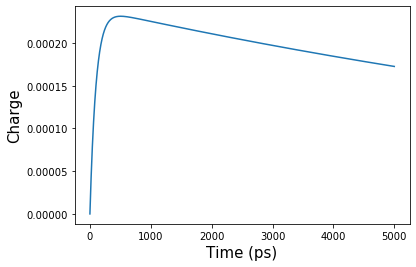

In [3]:
plt.plot(time, spe_resp)
plt.xlabel('Time (ps)', fontsize=15)
plt.ylabel('Charge'   , fontsize=15)
plt.show()

## Main code:

In [4]:
evt              = 0
file_name        = '/Users/carmenromoluque/ANTEA/antea/testdata/full_body_1ev.h5'
tof_response     = load_mcTOFsns_response(file_name)
evt_tof          = tof_response[tof_response.event_id==evt]
tof_sns          = evt_tof.sensor_id.unique()

tof_bin_size = read_sensor_bin_width_from_conf(file_name, tof=True)
times = evt_tof.time_bin.values * tof_bin_size / units.ps
evt_tof.insert(len(evt_tof.columns), 'time', times.astype(int)) # here we have bins of 1 ps

evt_tof_exp_dist = []

# Loop overall the sensors seeing charge
for s_id in tof_sns:
    tdc_conv     = tf.tdc_convolution(evt_tof, spe_resp, s_id, time_window)
    # Translation from the array to a tof_waveform dataframe
    tdc_conv_df  = tf.translate_charge_conv_to_wf_df(evt, s_id, tdc_conv)
    evt_tof_exp_dist.append(tdc_conv_df)
evt_tof_exp_dist = pd.concat(evt_tof_exp_dist)

evt_tof_exp_dist.head()

,event_id,sensor_id,time,charge
0,0,-48411,1671,0.000002
1,0,-48411,1672,0.000005
2,0,-48411,1673,0.000007
3,0,-48411,1674,0.000009
4,0,-48411,1675,0.000012


In [5]:
## This functions are the TOF discrete case in order to compare with the case distribution added.
def no_convolve_tof(spe_resp, signal):
    no_conv_zeros = np.zeros(len(spe_resp)-1)
    no_conv_first = np.hstack([1., no_conv_zeros, np.zeros(len(signal)-1)])
    no_conv_res   = np.zeros(len(spe_resp)+len(signal)-1)
    pe_pos        = np.argwhere(signal > 0)
    pe_recov      = signal[pe_pos]
    for i,j in enumerate(pe_recov):
        desp     = np.roll(no_conv_first*j, pe_pos[i])
        no_conv_res = desp + no_conv_res
    return no_conv_res

def tdc_no_convolution(tof_response, spe_response, s_id, time_window):
    pe_vect = np.zeros(time_window)
    sel_tof = tof_response[(tof_response.sensor_id == s_id) &
                           (tof_response.time < time_window)]
    pe_vect[sel_tof.time.values] = sel_tof.charge.values
    tdc_conv = no_convolve_tof(spe_response, pe_vect)
    return tdc_conv

### Plotting the distribution:

In [6]:
## Choosing a sensor id as an example:
s_id        = -53371
tdc_conv    = tf.tdc_convolution(evt_tof, spe_resp, s_id, time_window)
tdc_no_conv = tdc_no_convolution(evt_tof, spe_resp, s_id, time_window)

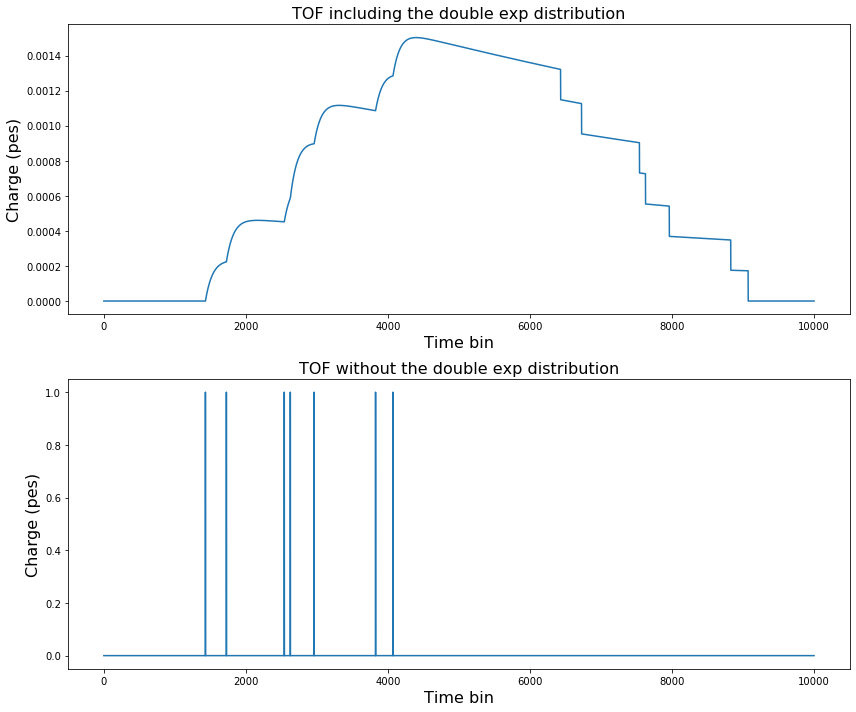

7.0
7.0


In [7]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,10))
ax1.plot(np.arange(0, len(tdc_conv)), tdc_conv   )
ax2.plot(np.arange(0, len(tdc_conv)), tdc_no_conv)
ax1.set_ylabel('Charge (pes)', size=16)
ax2.set_ylabel('Charge (pes)', size=16)
ax1.set_xlabel(    'Time bin', size=16)
ax2.set_xlabel(    'Time bin', size=16)
ax1.set_title('TOF including the double exp distribution', size=16)
ax2.set_title('TOF without the double exp distribution'  , size=16)
plt.tight_layout()
plt.show()

print(np.sum(tdc_conv))
print(np.sum(tdc_no_conv))

### Adding thresholds:

In [8]:
timestamp_thr = np.array([0.5, 1, 1.5, 2, 2.5])
timestamp_thr = timestamp_thr/norm # Important to divide by the normalization
print(timestamp_thr)
for t_thr in timestamp_thr:
    new_tof = evt_tof_exp_dist[evt_tof_exp_dist.charge > t_thr]
    print(new_tof.head())

[0.00011567 0.00023135 0.00034702 0.0004627  0.00057837]
    event_id  sensor_id  time    charge
49         0     -48411  1720  0.000117
50         0     -48411  1721  0.000123
51         0     -48411  1722  0.000129
52         0     -48411  1723  0.000134
53         0     -48411  1724  0.000140
    event_id  sensor_id  time    charge
71         0     -48411  1742  0.000235
72         0     -48411  1743  0.000240
73         0     -48411  1744  0.000245
74         0     -48411  1745  0.000249
75         0     -48411  1746  0.000254
    event_id  sensor_id  time    charge
93         0     -48411  1764  0.000351
94         0     -48411  1765  0.000357
95         0     -48411  1766  0.000362
96         0     -48411  1767  0.000368
97         0     -48411  1768  0.000374
     event_id  sensor_id  time    charge
114         0     -48411  1785  0.000465
115         0     -48411  1786  0.000470
116         0     -48411  1787  0.000474
117         0     -48411  1788  0.000479
118         0     

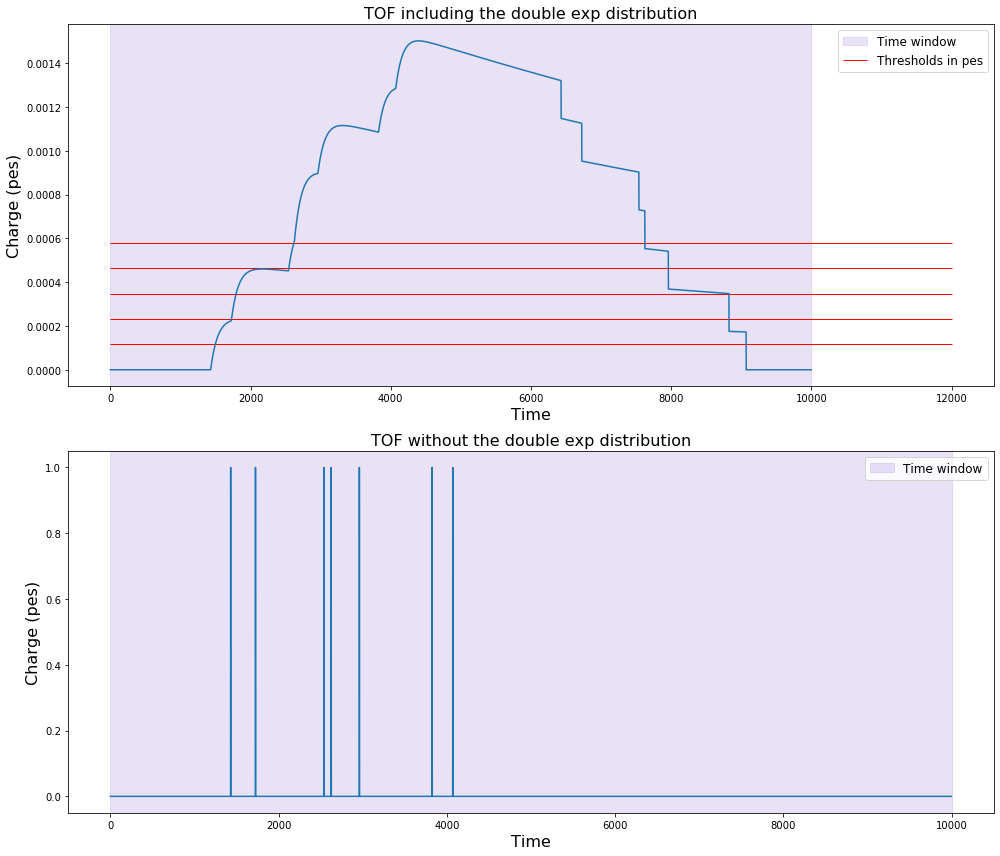

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14,12))
ax1.plot(np.arange(0, len(tdc_conv)), tdc_conv)
ax1.hlines(timestamp_thr, 0, 12000, 'r', lw=1, label='Thresholds in pes')
ax1.axvspan(0, 10000, alpha=0.2, color='mediumpurple', label='Time window')
ax2.plot(np.arange(0, len(tdc_no_conv)), tdc_no_conv)
ax2.axvspan(0, 10000, alpha=0.2, color='mediumpurple', label='Time window')
ax1.set_ylabel('Charge (pes)', size=16)
ax2.set_ylabel('Charge (pes)', size=16)
ax1.set_xlabel(        'Time', size=16)
ax2.set_xlabel(        'Time', size=16)
ax1.set_title('TOF including the double exp distribution', size=16)
ax2.set_title('TOF without the double exp distribution'  , size=16)
ax1.legend(fontsize=12)
ax2.legend(fontsize=12)
plt.tight_layout()
plt.show()